In [1]:
!pip uninstall numpy scikit-learn xgboost joblib -y
!pip install numpy==1.26.4 scikit-learn xgboost joblib audiomentations librosa soundfile matplotlib seaborn pandas tqdm gradio -q
print("Libraries reinstalled.")

!pip uninstall numpy -y
!pip install numpy==1.26.4 -q
!pip uninstall numpy scikit-learn xgboost joblib -y
!pip install numpy==1.26.4 scikit-learn xgboost joblib audiomentations librosa soundfile matplotlib seaborn pandas tqdm gradio -q
print("Libraries reinstalled.")


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: xgboost 2.1.4
Uninstalling xgboost-2.1.4:
  Successfully uninstalled xgboost-2.1.4
Found existing installation: joblib 1.4.2
Uninstalling joblib-1.4.2:
  Successfully uninstalled joblib-1.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 22.4 MB/s 

GPU detected: Tesla T4
Mounted at /content/drive
Google Drive mounted.
Checking for dataset in /content/hi_kia_dataset...
Dataset files not found. Attempting extraction from /content/drive/MyDrive/hi_kia_1.0.tar.gz...
Extracted files to: /content/hi_kia_dataset

Annotation data loaded successfully.
Total samples in annotation file: 488
Emotion distribution:
emo
sad        133
happy      129
neutral    119
angry      107
Name: count, dtype: int64


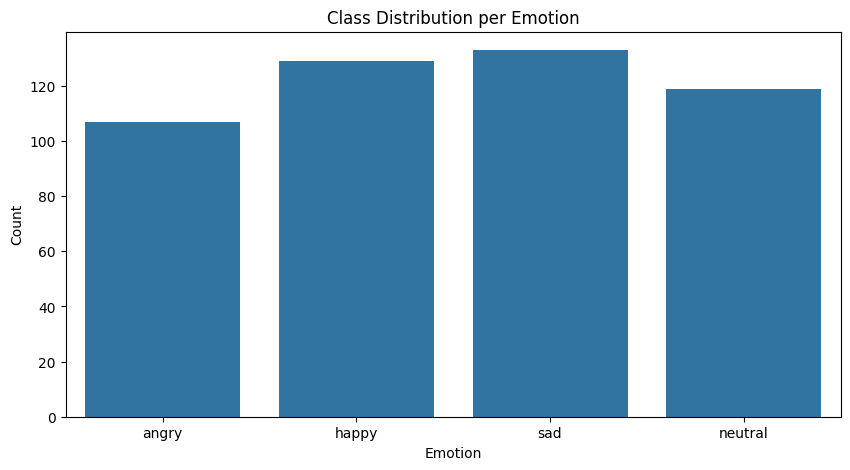


Extracting ENHANCED features (with augmentation)...
Identified 390 indices for potential augmentation.


Processing Audio:   0%|          | 0/488 [00:00<?, ?it/s]

Determined feature vector length: 376

Saving expected feature length (376) to expected_feature_length.pkl

Successfully extracted features for 488 samples.
Feature matrix shape (X): (488, 376)
Label array shape (y): (488,)


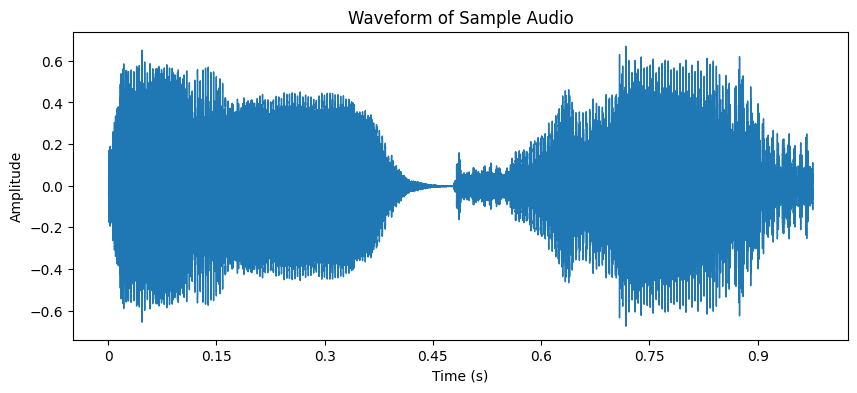

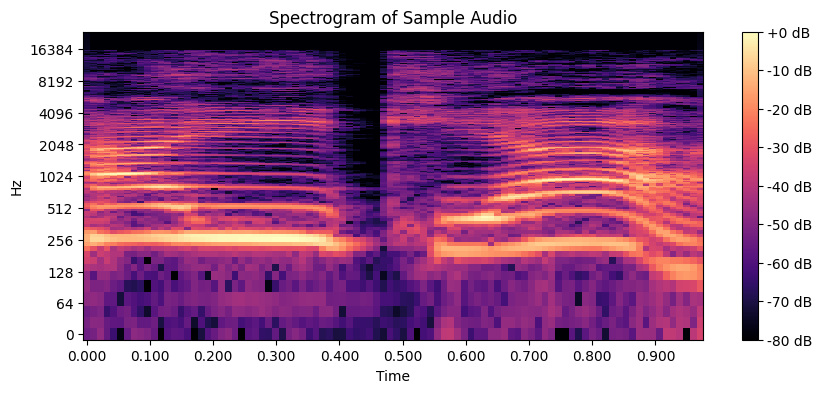

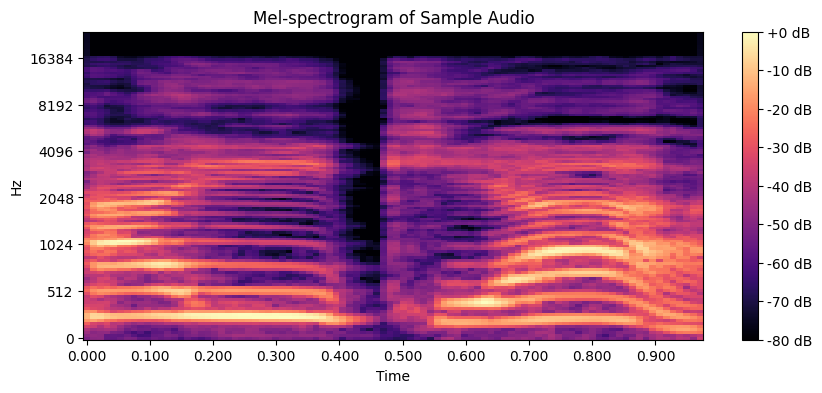


Encoding labels...
Label mapping: {'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3}

Scaling features...
Features scaled.
Saving Scaler to feature_scaler.pkl
Saving Label Encoder to label_encoder.pkl


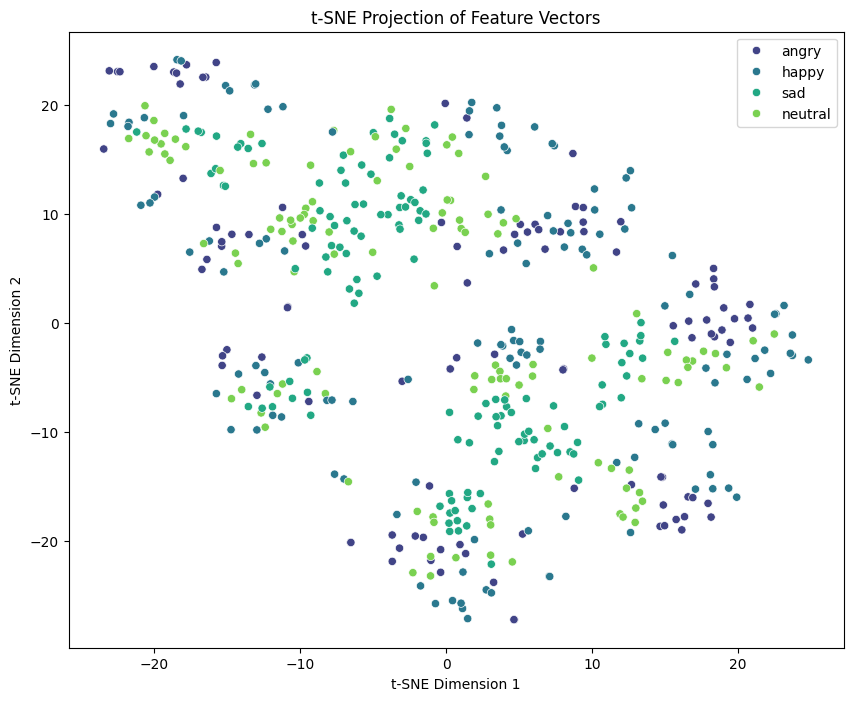

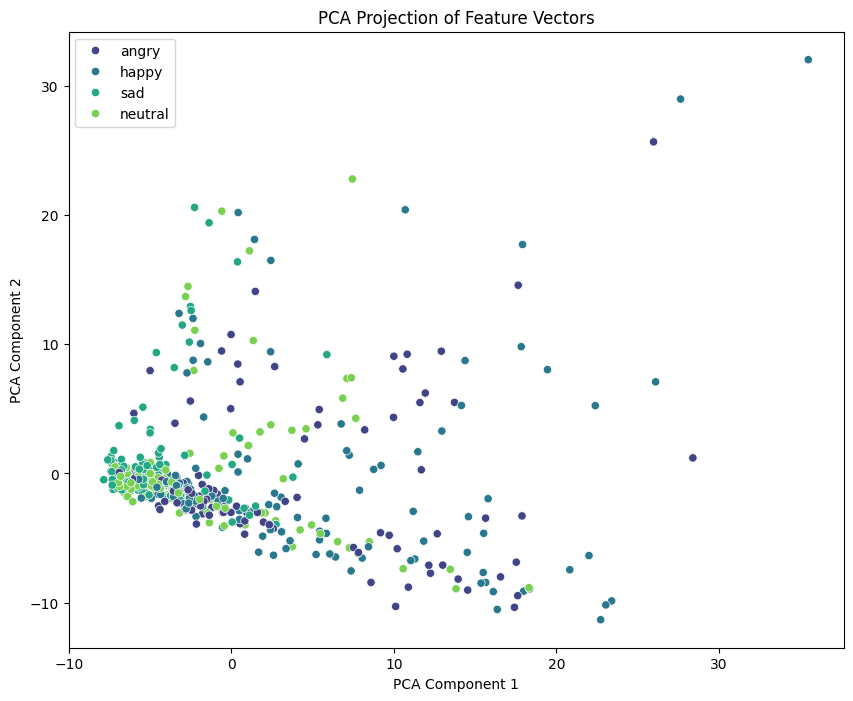


Splitting scaled data into training and testing sets (80/20)...
Training data shape: (390, 376), Test data shape: (98, 376)

--- Tuning XGBoost Hyperparameters using GridSearchCV (GPU if available) ---
XGBoost will use GPU.
Starting GridSearchCV (n_jobs=1, tree_method='gpu_hist')...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=150

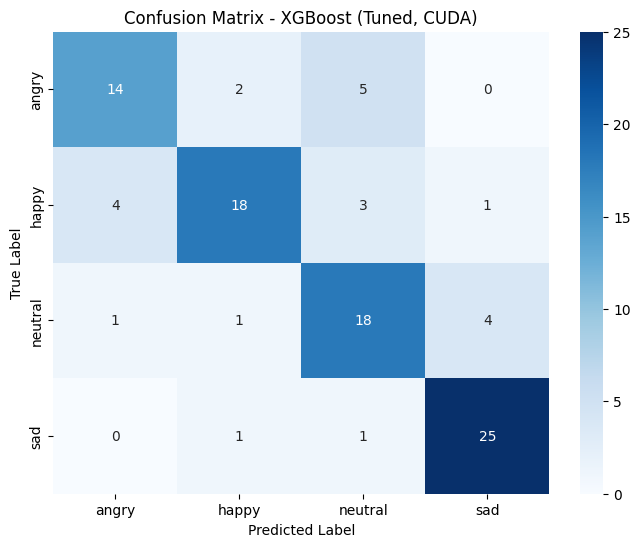

Saving Best Tuned Model to best_tuned_ser_model.pkl


In [1]:

import os
import librosa
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
import warnings
import pickle
import gradio as gr
import time
import torch

import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

if torch.cuda.is_available():
    print(f"GPU detected: {torch.cuda.get_device_name(0)}")
    device = 'cuda'
else:
    print("No GPU detected, XGBoost will run on CPU (slower).")
    device = 'cpu'

DRIVE_TAR_GZ_PATH = "/content/drive/MyDrive/hi_kia_1.0.tar.gz"
LOCAL_TAR_GZ_PATH = "hi_kia_1.0.tar.gz"
N_MFCC = 13
AUGMENT_RATIO = 0.6
EXTRACT_DIR_COLAB = "/content/hi_kia_dataset"
EXTRACT_DIR_LOCAL = "hi_kia_dataset"
SCALER_PATH = "feature_scaler.pkl"
LABEL_ENCODER_PATH = "label_encoder.pkl"
BEST_MODEL_PATH = "best_tuned_ser_model.pkl"
FEATURE_LENGTH_PATH = "expected_feature_length.pkl" # Path to save the feature length

EXPECTED_FEATURE_LENGTH = -1

colab_env = False
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    TAR_GZ_PATH = DRIVE_TAR_GZ_PATH
    EXTRACT_DIR = EXTRACT_DIR_COLAB
    print("Google Drive mounted.")
    colab_env = True
except ImportError:
    print("Not running in Colab, using local paths.")
    TAR_GZ_PATH = LOCAL_TAR_GZ_PATH
    EXTRACT_DIR = EXTRACT_DIR_LOCAL
    colab_env = False

ANNOTATION_CSV_PATH = os.path.join(EXTRACT_DIR, "hi_kia", "annotation", "annotation.csv")
AUDIO_BASE_PATH = os.path.join(EXTRACT_DIR, "hi_kia", "wav")

os.makedirs(EXTRACT_DIR, exist_ok=True)
print(f"Checking for dataset in {EXTRACT_DIR}...")
if not os.path.exists(ANNOTATION_CSV_PATH) or not os.path.exists(AUDIO_BASE_PATH):
    print(f"Dataset files not found. Attempting extraction from {TAR_GZ_PATH}...")
    if os.path.exists(TAR_GZ_PATH):
        try:
            with tarfile.open(TAR_GZ_PATH, "r:gz") as tar:
                tar.extractall(path=EXTRACT_DIR)
            print(f"Extracted files to: {EXTRACT_DIR}")
            if not os.path.exists(ANNOTATION_CSV_PATH) or not os.path.exists(AUDIO_BASE_PATH):
                 raise FileNotFoundError("Extraction failed or core dataset files missing.")
        except Exception as e:
            print(f"ERROR during extraction: {e}")
            raise
    else:
         raise FileNotFoundError(f"ERROR: Tar GZ file not found at {TAR_GZ_PATH}.")
else:
    print("Dataset already appears to be extracted.")


# @title 6. Load Annotations
try:
    df_annotations = pd.read_csv(ANNOTATION_CSV_PATH)
    print("\nAnnotation data loaded successfully.")
    print(f"Total samples in annotation file: {len(df_annotations)}")
    print("Emotion distribution:")
    print(df_annotations['emo'].value_counts())
    if 'Unnamed: 0' not in df_annotations.columns:
        raise KeyError("'Unnamed: 0' column missing.")
except Exception as e:
    print(f"ERROR loading annotations: {e}")
    raise

plt.figure(figsize=(10, 5))
sns.countplot(x='emo', data=df_annotations)
plt.title('Class Distribution per Emotion')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

augmenter = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.010, p=0.3),
    TimeStretch(min_rate=0.85, max_rate=1.15, p=0.3),
    PitchShift(min_semitones=-3, max_semitones=3, p=0.3),
])

def extract_enhanced_features_from_data(y, sr, expected_length=-1):
    """ Extracts features from pre-loaded audio data. Checks against expected_length. """
    try:
        if np.max(np.abs(y)) < 1e-5: return None # Skip silent audio

        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
        mfccs_delta = librosa.feature.delta(mfccs)
        mfccs_delta2 = librosa.feature.delta(mfccs, order=2)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        rms = librosa.feature.rms(y=y)

        def get_stats(feature_matrix):
            shape = feature_matrix.shape
            if feature_matrix is None or feature_matrix.size == 0:
                return np.zeros(shape[0] * 2 if len(shape) > 1 else 2)
            means = np.mean(feature_matrix.T, axis=0)
            stds = np.std(feature_matrix.T, axis=0)
            stds = np.nan_to_num(stds)
            return np.hstack((means, stds))

        mfccs_stats, mfccs_delta_stats, mfccs_delta2_stats = get_stats(mfccs), get_stats(mfccs_delta), get_stats(mfccs_delta2)
        chroma_stats, mel_stats, contrast_stats = get_stats(chroma), get_stats(mel), get_stats(contrast)
        zcr_stats, rms_stats = get_stats(zcr), get_stats(rms)

        all_features = np.hstack((
            mfccs_stats, mfccs_delta_stats, mfccs_delta2_stats,
            chroma_stats, mel_stats, contrast_stats, zcr_stats, rms_stats
        ))

        current_length = all_features.shape[0]

        if expected_length > 0 and current_length != expected_length:
             print(f"Warning: Feature length mismatch. Expected {expected_length}, got {current_length}. Skipping sample.")
             return None

        if not np.all(np.isfinite(all_features)):
            all_features = np.nan_to_num(all_features, nan=0.0, posinf=0.0, neginf=0.0)
            if expected_length > 0 and all_features.shape[0] != expected_length:
                print("Warning: Feature length mismatch after NaN handling. Skipping sample.")
                return None

        return all_features
    except Exception as e:
        return None

print("\nExtracting ENHANCED features (with augmentation)...")
features_list = []
labels_list = []
indices_to_keep = []

available_wav_files = set(os.listdir(AUDIO_BASE_PATH))
temp_indices = df_annotations.index
temp_labels = df_annotations['emo'].values
train_indices_set = set()
if len(temp_indices) > 1 and len(np.unique(temp_labels)) > 1:
    train_indices, _, _, _ = train_test_split(temp_indices, temp_labels, test_size=0.2, random_state=42, stratify=temp_labels)
    train_indices_set = set(train_indices)
    print(f"Identified {len(train_indices_set)} indices for potential augmentation.")

_local_expected_feature_length = -1

for index, row in tqdm(df_annotations.iterrows(), total=len(df_annotations), desc="Processing Audio"):
    base_filename = row['Unnamed: 0']
    file_name = f"{base_filename}.wav"
    file_path = os.path.join(AUDIO_BASE_PATH, file_name)
    emotion_label = row['emo'].lower()
    is_training_sample = index in train_indices_set
    should_augment = is_training_sample and (np.random.rand() < AUGMENT_RATIO)

    if file_name in available_wav_files:
        try:
            y_audio, sr = librosa.load(file_path, sr=None, res_type='kaiser_fast')
            current_features = None
            if should_augment:
                y_augmented = augmenter(samples=y_audio, sample_rate=sr)
                current_features = extract_enhanced_features_from_data(y_augmented, sr, _local_expected_feature_length)
            else:
                current_features = extract_enhanced_features_from_data(y_audio, sr, _local_expected_feature_length)

            if _local_expected_feature_length <= 0 and current_features is not None:
                _local_expected_feature_length = current_features.shape[0]
                print(f"Determined feature vector length: {_local_expected_feature_length}")

            if current_features is not None and current_features.shape[0] == _local_expected_feature_length:
                 features_list.append(current_features)
                 labels_list.append(emotion_label)
                 indices_to_keep.append(index)
            elif current_features is not None:
                 print(f"Skipping {file_name} due to feature length mismatch.")

        except Exception as e:
            # print(f"Skipping {file_name} due to error during loading/augmentation: {e}") # Verbose
            continue

X = np.array(features_list)
y = np.array(labels_list)
if len(X) > 0:
    df_processed = df_annotations.loc[indices_to_keep].reset_index(drop=True)
    EXPECTED_FEATURE_LENGTH = X.shape[1] # Use the actual shape after stacking
    print(f"\nSaving expected feature length ({EXPECTED_FEATURE_LENGTH}) to {FEATURE_LENGTH_PATH}")
    with open(FEATURE_LENGTH_PATH, 'wb') as f:
        pickle.dump(EXPECTED_FEATURE_LENGTH, f)
else:
    df_processed = pd.DataFrame(columns=df_annotations.columns)
    EXPECTED_FEATURE_LENGTH = -1 # Indicate failure

print(f"\nSuccessfully extracted features for {len(X)} samples.")
if len(X) > 0:
    print(f"Feature matrix shape (X): {X.shape}")
    print(f"Label array shape (y): {y.shape}")
    if len(X) != len(y) or len(X) != len(df_processed):
         raise ValueError("Mismatch in final data lengths")
    if X.shape[1] != EXPECTED_FEATURE_LENGTH:
         print(f"WARNING: Final X width ({X.shape[1]}) != saved expected ({EXPECTED_FEATURE_LENGTH}).")
else:
    print("WARNING: No features were successfully extracted.")

sample_audio_file = os.path.join(AUDIO_BASE_PATH, df_annotations['Unnamed: 0'][0] + '.wav')
y_sample, sr_sample = librosa.load(sample_audio_file, sr=None)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(y_sample, sr=sr_sample)
plt.title('Waveform of Sample Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(10, 4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y_sample)), ref=np.max)
librosa.display.specshow(D, sr=sr_sample, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Sample Audio')
plt.show()

plt.figure(figsize=(10, 4))
S = librosa.feature.melspectrogram(y=y_sample, sr=sr_sample, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, sr=sr_sample, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-spectrogram of Sample Audio')
plt.show()

if len(X) > 0:
    print("\nEncoding labels...")
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    print(f"Label mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

    print("\nScaling features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("Features scaled.")

    print(f"Saving Scaler to {SCALER_PATH}")
    with open(SCALER_PATH, 'wb') as f: pickle.dump(scaler, f)
    print(f"Saving Label Encoder to {LABEL_ENCODER_PATH}")
    with open(LABEL_ENCODER_PATH, 'wb') as f: pickle.dump(label_encoder, f)

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='viridis')
    plt.title('t-SNE Projection of Feature Vectors')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis')
    plt.title('PCA Projection of Feature Vectors')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

else:
    print("\nSkipping label encoding, scaling, and training.")


# @title 10. Hyperparameter Tuning (XGBoost GPU) & Model Training/Evaluation
best_model_name = "N/A"
accuracy = 0.0
BEST_MODEL_PATH = None

if len(X) > 1 and len(np.unique(y_encoded)) > 1:
    start_time_grid = time.time()
    print("\nSplitting scaled data into training and testing sets (80/20)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

    print("\n--- Tuning XGBoost Hyperparameters using GridSearchCV (GPU if available) ---")
    param_grid = {
        'n_estimators': [150, 300], 'max_depth': [5, 8],
        'learning_rate': [0.1, 0.15], 'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    xgb_params = {
        'objective': 'multi:softmax', 'num_class': len(label_encoder.classes_),
        'eval_metric': 'mlogloss', 'random_state': 42, 'use_label_encoder': False
    }
    if device == 'cuda':
        xgb_params['tree_method'] = 'gpu_hist'
        print("XGBoost will use GPU.")
    else:
        xgb_params['tree_method'] = 'hist'
        print("XGBoost will use CPU.")

    xgb = XGBClassifier(**xgb_params)
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy',
                               cv=cv, n_jobs=1, verbose=2)

    print(f"Starting GridSearchCV (n_jobs=1, tree_method='{xgb_params['tree_method']}')...")
    grid_search.fit(X_train, y_train)
    end_time_grid = time.time()
    print(f"GridSearchCV finished in {end_time_grid - start_time_grid:.2f} seconds.")

    print(f"\nBest Parameters found: {grid_search.best_params_}")
    print(f"Best Cross-validation Accuracy: {grid_search.best_score_:.4f}")

    best_model = grid_search.best_estimator_
    best_model_name = f"XGBoost (Tuned, {device.upper()})"

    print(f"\n--- Evaluating Best Tuned Model ({best_model_name}) on Test Set ---")
    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_labels = label_encoder.classes_

    print(f"\n{best_model_name} Test Set Evaluation Metrics:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print("\nClassification Report:\n", class_report)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {best_model_name}")
    plt.show()

    BEST_MODEL_PATH = "best_tuned_ser_model.pkl"
    print(f"Saving Best Tuned Model to {BEST_MODEL_PATH}")
    with open(BEST_MODEL_PATH, 'wb') as f: pickle.dump(best_model, f)

else:
    print("\nSkipping model training and evaluation due to insufficient data.")

In [2]:
import plotly.graph_objects as go
from sklearn.metrics import classification_report

# ... (your existing code for model training and evaluation) ...

# Assuming you have y_test and y_pred from your model evaluation
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Get a sample class to extract metrics
sample_class = list(report.keys())[0]  # Get the first class
if sample_class not in ['accuracy', 'macro avg', 'weighted avg']:
    metrics = list(report[sample_class].keys())  # ['precision', 'recall', 'f1-score', 'support']
else:
    sample_class = list(report.keys())[1]  # Try the second class
    metrics = list(report[sample_class].keys())  # ['precision', 'recall', 'f1-score', 'support']

classes = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'

values = [[report[c][m] for m in metrics] for c in classes]

fig = go.Figure(data=[go.Table(
    header=dict(values=['Class'] + metrics),
    cells=dict(values=[classes] + values)
)])

fig.update_layout(title='Classification Report')

fig.show()

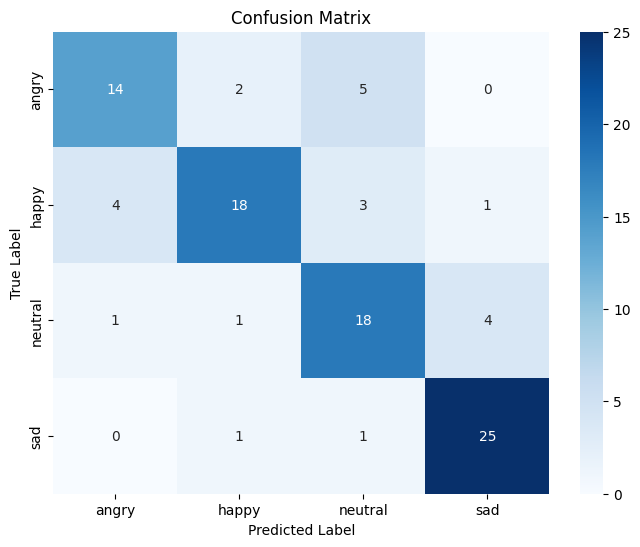

In [3]:
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# ... (your existing code for model training and evaluation) ...

# Assuming you have y_test and y_pred from your model evaluation
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


metrics = ['precision', 'recall', 'f1-score']
classes = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
values = [[report[c][m] for m in metrics] for c in classes]

fig = go.Figure()
for i, metric in enumerate(metrics):
    fig.add_trace(go.Bar(
        x=classes,
        y=[v[i] for v in values],
        name=metric
    ))

fig.update_layout(
    title='Precision, Recall, and F1-score per Class',
    xaxis_title='Emotion Class',
    yaxis_title='Score',
    barmode='group'
)
fig.show()

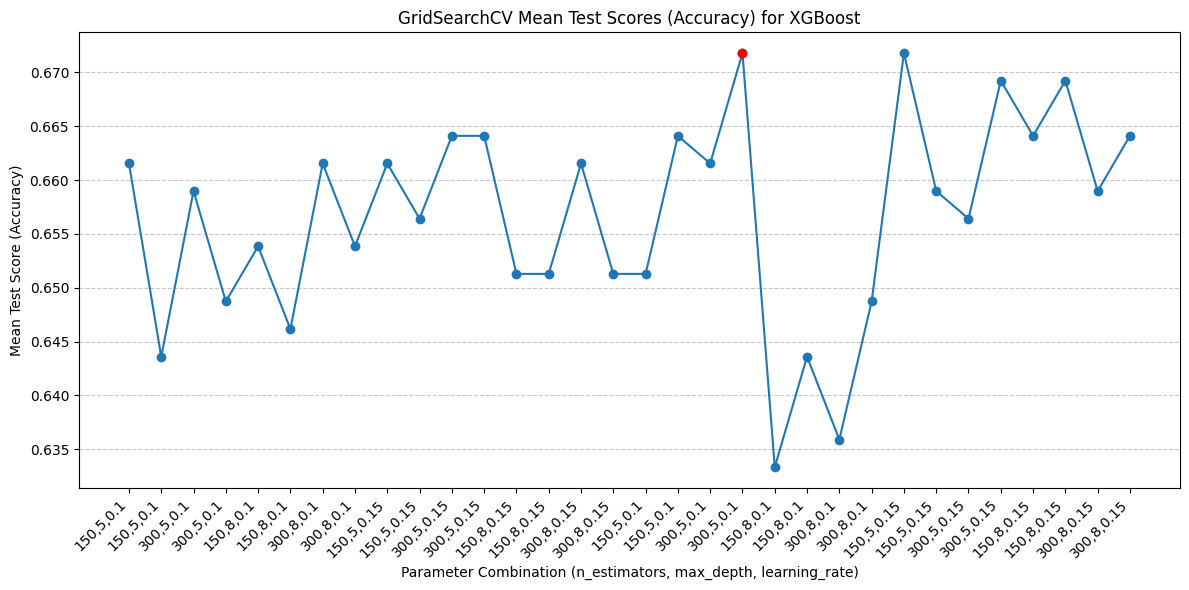

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# --- Get parameter values from grid_search.cv_results_ ---
param_values = [
    grid_search.cv_results_['params'][i]
    for i in range(len(grid_search.cv_results_['params']))
]
mean_test_scores = grid_search.cv_results_['mean_test_score']

# --- Create a list of parameter names for x-axis labels ---
param_labels = [
    f"{params['n_estimators']},{params['max_depth']},{params['learning_rate']}"
    for params in param_values
]

plt.figure(figsize=(12, 6))  # Adjust figure size if needed
plt.plot(mean_test_scores, marker='o')  # Use markers for better visibility

best_idx = np.argmax(mean_test_scores)
plt.plot(best_idx, mean_test_scores[best_idx], 'ro')  # red circle for best score
plt.annotate(f"Best: {mean_test_scores[best_idx]:.4f}",
             (best_idx, mean_test_scores[best_idx] + 0.002))  # annotate best score

plt.title('GridSearchCV Mean Test Scores (Accuracy) for XGBoost')  # More specific title
plt.ylabel('Mean Test Score (Accuracy)')
plt.xlabel('Parameter Combination (n_estimators, max_depth, learning_rate)')
plt.xticks(range(len(mean_test_scores)), param_labels, rotation=45, ha='right')  # Rotate x-axis labels
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid
plt.tight_layout()  # Adjust layout to avoid label overlaps
plt.show()

In [9]:
# prompt: implement a cool, attractive, next gen  interactive gradio interface to get input both from mic and local file upload then predict emotion with confidence scores.

# @title 14. Gradio Interface for Prediction
# Load the scaler, label encoder, model, and expected feature length
try:
    with open(SCALER_PATH, 'rb') as f:
        loaded_scaler = pickle.load(f)
    with open(LABEL_ENCODER_PATH, 'rb') as f:
        loaded_label_encoder = pickle.load(f)
    with open(BEST_MODEL_PATH, 'rb') as f:
        loaded_model = pickle.load(f)
    with open(FEATURE_LENGTH_PATH, 'rb') as f:
        loaded_expected_feature_length = pickle.load(f)
    print("Loaded scaler, label encoder, model, and expected feature length for inference.")
except FileNotFoundError as e:
    print(f"Error loading necessary files for inference: {e}")
    loaded_scaler, loaded_label_encoder, loaded_model, loaded_expected_feature_length = None, None, None, -1
    print("Inference will not be possible.")

def predict_emotion(audio_data):
    """Predicts emotion from a given audio tuple (sr, y)."""
    if loaded_model is None or loaded_scaler is None or loaded_label_encoder is None or loaded_expected_feature_length <= 0:
        return "Model not loaded or data missing."

    sr, y = audio_data
    if y is None or len(y) == 0:
        return {"Prediction": "No audio data provided."}

    # Ensure audio data is in the correct format (e.g., mono if the model was trained on mono)
    if y.ndim > 1:
        y = librosa.to_mono(y)

    try:
        # Extract features from the live/uploaded audio
        # Do NOT augment the inference audio
        features = extract_enhanced_features_from_data(y, sr, loaded_expected_feature_length)

        if features is None or features.shape[0] != loaded_expected_feature_length:
             print(f"Warning: Feature extraction failed or length mismatch for input audio. Got {features.shape[0] if features is not None else 'None'}, expected {loaded_expected_feature_length}.")
             return {"Prediction": "Error extracting features from audio."}

        # Scale the features using the loaded scaler
        features_scaled = loaded_scaler.transform(features.reshape(1, -1))

        # Predict probabilities
        probabilities = loaded_model.predict_proba(features_scaled)[0]

        # Get the predicted class index
        predicted_class_idx = np.argmax(probabilities)

        # Get the predicted class label
        predicted_emotion = loaded_label_encoder.inverse_transform([predicted_class_idx])[0]

        # Get all emotion labels and their confidence scores
        confidence_scores = {}
        for i, label in enumerate(loaded_label_encoder.classes_):
            confidence_scores[label] = probabilities[i]

        # Format the output
        result = {"Prediction": predicted_emotion}
        # Sort confidence scores from highest to lowest
        sorted_scores = sorted(confidence_scores.items(), key=lambda item: item[1], reverse=True)
        for label, score in sorted_scores:
            result[f"{label.capitalize()} Confidence"] = f"{score:.4f}"

        return result

    except Exception as e:
        print(f"Error during prediction: {e}")
        return {"Prediction": f"An error occurred during prediction: {e}"}

if loaded_model is not None:
    print("\nSetting up Gradio Interface...")
    # Define the Gradio Interface
    # Using both Microphone and Audio Upload components
    audio_input = gr.Audio(sources=["microphone", "upload"], label="Input Audio (Microphone or Upload)")
    output_text = gr.JSON(label="Emotion Prediction and Confidence Scores")

    # Create the interface
    interface = gr.Interface(
        fn=predict_emotion,  # Your prediction function
        inputs=audio_input,    # Input component(s)
        outputs=output_text,   # Output component(s)
        title="Speech Emotion Recognition",
        description="Speak into the microphone or upload an audio file (.wav, .mp3, etc.) to predict the emotion. Uses a pre-trained XGBoost model.",
        theme="soft" # A pleasant theme
    )

    # Launch the interface
    interface.launch(share=True, debug=True)
else:
    print("\nSkipping Gradio interface setup because the model was not loaded successfully.")


Loaded scaler, label encoder, model, and expected feature length for inference.

Setting up Gradio Interface...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://68a684e059901cc74c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b5e9ddad1ca4565ddc.gradio.live
Killing tunnel 127.0.0.1:7861 <> https://68a684e059901cc74c.gradio.live


In [10]:
!pip freeze > requirements.txt

ABOVE RIGHT CODE